# MODELO FEDERADO

## IMPORTAR LIBRERÍAS

In [1]:
import os
import copy
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import random

## SEMILLA POR REPRODUCIBILIDAD

In [2]:
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

## PREPROCESO DE LOS DATOS

In [3]:
folder_path = r"C:\Users\Ibon\PycharmProjects\Microgrid\TrainTestSplit"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def load_and_preprocess(files, all_sources):
    df_list = []
    for file in files:
        file_path = os.path.join(folder_path, file)
        df = pd.read_csv(file_path, parse_dates=["Time Stamp (local standard time) yyyy-mm-ddThh:mm:ss"])
        df = df.drop(columns='Time Stamp (local standard time) yyyy-mm-ddThh:mm:ss')
        df_sampled = df.groupby('source', group_keys=False).apply(lambda x: x.sample(frac=0.4, random_state=42))
        df_list.append(df_sampled)
    full_df = pd.concat(df_list, ignore_index=True)
    
    full_df['source'] = pd.Categorical(full_df['source'], categories=all_sources)
    full_df = pd.get_dummies(full_df, columns=['source'], prefix='src', dtype=np.float32)
    
    return full_df

def prepare_data(df, scaler=None):
    X = df.drop(columns=['Pmp (W)']).values.astype(np.float32)
    y = df['Pmp (W)'].values.astype(np.float32)
    if scaler is None:
        scaler = StandardScaler()
        X = scaler.fit_transform(X)
    else:
        X = scaler.transform(X)
    X_tensor = torch.tensor(X).to(device)
    y_tensor = torch.tensor(y).unsqueeze(1).to(device)
    return X_tensor, y_tensor, scaler

In [4]:
class EnhancedDNN(nn.Module):
    def __init__(self, input_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(512, 256),
            nn.BatchNorm1d(256),
            nn.ReLU(),
            nn.Dropout(0.4),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
        
    def forward(self, x):
        return self.model(x)

## DEFINICIÓN DE LOS HIPERPARÁMETROS
En este caso, se simulará un proceso federado de 5 rondas de 40 épocas cada una para cada uno de los clientes. El resto de hiperparámetros son los mismos que en el modelo centralizado

In [5]:
federated_rounds = 1       
local_epochs = 2          
batch_size = 512
lr = 0.0001
weight_decay = 1e-4

## SEPARACIÓN DE LOS DATOS
Se cogen los datos ya separados en el notebook TrainTestSplit

In [6]:
clients = {
    "cocoa": [f for f in os.listdir(folder_path) if f.endswith('.csv') and "train" in f and "cocoa" in f.lower()],
    "eugene": [f for f in os.listdir(folder_path) if f.endswith('.csv') and "train" in f and "eugene" in f.lower()],
    "golden": [f for f in os.listdir(folder_path) if f.endswith('.csv') and "train" in f and "golden" in f.lower()]
}

test_files = [f for f in os.listdir(folder_path) if f.endswith('.csv') and "test" in f]


## COGER COLUMNA SOURCE DEL ORIGEN ESPECÍFICO

In [7]:
all_sources = set()

for client_files in clients.values():
    for file in client_files:
        file_path = os.path.join(folder_path, file)
        df_temp = pd.read_csv(file_path, usecols=['source'])
        all_sources.update(df_temp['source'].unique())


all_sources = sorted(all_sources) 

In [8]:
temp_df = load_and_preprocess(clients["cocoa"], all_sources)
X_temp, y_temp, scaler = prepare_data(temp_df)  

test_df = load_and_preprocess(test_files, all_sources)

input_dim = X_temp.shape[1]

## INICIALIZACIÓN DEL MODELO Y CARGA DE PESOS DEL MODELO CENTRALIZADO

In [9]:
global_model = EnhancedDNN(input_dim).to(device)

global_model.train()

EnhancedDNN(
  (model): Sequential(
    (0): Linear(in_features=42, out_features=512, bias=True)
    (1): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=512, out_features=256, bias=True)
    (5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.4, inplace=False)
    (8): Linear(in_features=256, out_features=128, bias=True)
    (9): ReLU()
    (10): Linear(in_features=128, out_features=64, bias=True)
    (11): ReLU()
    (12): Linear(in_features=64, out_features=1, bias=True)
  )
)

## DEFINICIÓN DE LA FUNCIÓN DE ENTRENAMIENTO

In [10]:
def local_train(model, train_loader, criterion, optimizer, epochs):
    model.train()
    for epoch in range(epochs):
        running_loss = 0.0
        for xb, yb in train_loader:
            optimizer.zero_grad()
            outputs = model(xb)
            loss = criterion(outputs, yb)
            loss.backward()
            optimizer.step()
            running_loss += loss.item() * xb.size(0)
        avg_loss = running_loss / len(train_loader.dataset)
        print(f"Local epoch {epoch+1}, Loss: {avg_loss:.4f}")
    return model.state_dict(), len(train_loader.dataset)

## DEFINICIÓN DE LA FUNCIÓN FEDERAGED AVERAGING PARA COMBINAR LOS PESOS DE LOS MODELOS DE CADA CLIENTE

In [11]:
def fed_avg(state_dicts, data_sizes):
    avg_state = copy.deepcopy(state_dicts[0])
    total_samples = sum(data_sizes)

    for key in avg_state.keys():
        if avg_state[key].dtype in [torch.int64, torch.long]:
            avg_state[key] = state_dicts[0][key].clone()
        else:
            avg_state[key] = torch.zeros_like(avg_state[key], dtype=torch.float32)

            for state, size in zip(state_dicts, data_sizes):
                weight = size / total_samples
                avg_state[key] += state[key].float() * weight

    return avg_state

## ENTRENAMIENTO DE CADA CLIENTE Y ACTUALIZACIÓN DEL MODELO GLOBAL

In [12]:
criterion = nn.MSELoss()
best_test_loss = np.inf
best_federated_model_path = "best_federated_model.pth"

print("=== Iniciando entrenamiento federado ===")
for round in range(1, federated_rounds+1):
    print(f"\n--- Ronda Federada {round} ---")
    local_state_dicts = []
    data_sizes = []
    for client_name, files in clients.items():
        print(f"Entrenando cliente: {client_name}")
        client_df = load_and_preprocess(files, all_sources)
        X_local, y_local, _ = prepare_data(client_df, scaler)
        local_dataset = TensorDataset(X_local, y_local)
        local_loader = DataLoader(local_dataset, batch_size=batch_size, shuffle=True)
        
        local_model = copy.deepcopy(global_model)
        optimizer_local = optim.Adam(local_model.parameters(), lr=lr, weight_decay=weight_decay)
        
        local_state, n_samples = local_train(local_model, local_loader, criterion, optimizer_local, local_epochs)
        local_state_dicts.append(local_state)
        data_sizes.append(n_samples)
    
    global_state = fed_avg(local_state_dicts, data_sizes)
    global_model.load_state_dict(global_state)
    print(f"Ronda {round} completada. Se han promediado los pesos de {len(clients)} clientes.")
    
    X_test_tensor, y_test_tensor, _ = prepare_data(test_df, scaler)
    global_model.eval()
    with torch.no_grad():
        y_pred = global_model(X_test_tensor).cpu().numpy()
        y_test_np = y_test_tensor.cpu().numpy()
        test_loss = mean_squared_error(y_test_np, y_pred)
        print(f"Test MSE después de ronda {round}: {test_loss:.4f}")
    
    if test_loss < best_test_loss:
        best_test_loss = test_loss
        torch.save(global_model.state_dict(), best_federated_model_path)
        print(f"Nuevo mejor modelo federado guardado: {best_federated_model_path}")



=== Iniciando entrenamiento federado ===

--- Ronda Federada 1 ---
Entrenando cliente: cocoa
Local epoch 1, Loss: 1671.4202
Local epoch 2, Loss: 90.5189
Entrenando cliente: eugene
Local epoch 1, Loss: 1107.6035
Local epoch 2, Loss: 84.9002
Entrenando cliente: golden
Local epoch 1, Loss: 3292.0473
Local epoch 2, Loss: 2994.2332
Ronda 1 completada. Se han promediado los pesos de 3 clientes.
Test MSE después de ronda 1: 893.5952
Nuevo mejor modelo federado guardado: best_federated_model.pth


In [16]:
def plot_results(y_test_np, y_pred, titulo_extra=""):
    """
    Genera tres gráficos:
      1. Scatter plot de Predicciones vs Reales.
      2. Histograma de los residuos.
      3. Serie temporal de Predicciones vs Reales.
    Se puede agregar un título extra en cada figura.
    """
    plt.figure(figsize=(12, 4))
    
    # Gráfico 1: Predicciones vs Reales
    plt.subplot(131)
    plt.title('Predicciones vs Reales' + titulo_extra)
    plt.scatter(y_test_np, y_pred, alpha=0.3)
    plt.plot([y_test_np.min(), y_test_np.max()], [y_test_np.min(), y_test_np.max()], 'r--')
    plt.xlabel('Valores Reales')
    plt.ylabel('Predicciones')
    plt.grid(True)
    
    # Gráfico 2: Distribución de Residuos
    plt.subplot(132)
    residuals = y_test_np - y_pred
    plt.hist(residuals, bins=50, density=True, alpha=0.6)
    plt.title('Distribución de Residuos' + titulo_extra)
    plt.xlabel('Residuo')
    plt.grid(True)
    
    # Gráfico 3: Serie temporal de Predicciones vs Reales
    plt.subplot(133)
    plt.plot(y_pred, label="Predicciones")
    plt.plot(y_test_np, label="Valores Reales", alpha=0.7)
    plt.title('Serie Temporal' + titulo_extra)
    plt.xlabel('Muestras')
    plt.legend() 
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

C:\Users\Ibon\AppData\Local\Temp\ipykernel_9168\2191631061.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  global_model.load_state_dict(torch.load(best_federated_model_p


=== Evaluación del modelo global ===
Global Test MSE: 893.5952
Global Test MAE: 17.6558
Global Test R2: 0.3826


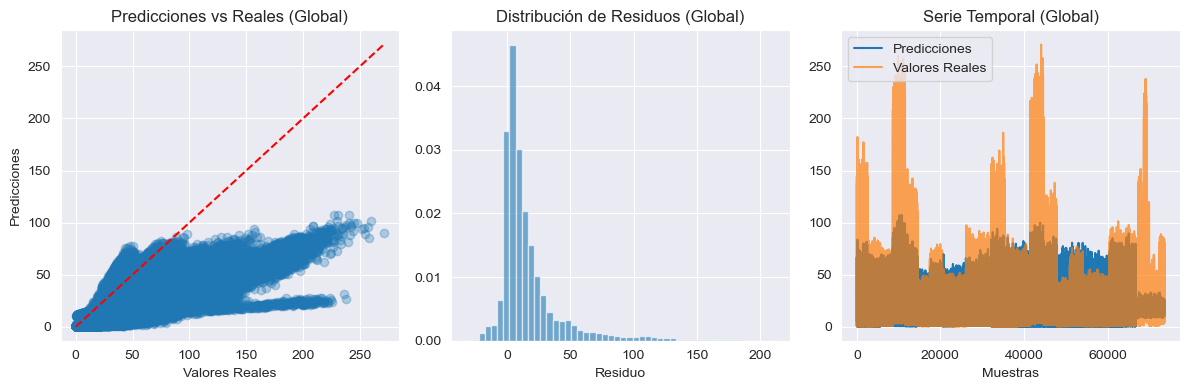


Evaluación del modelo global para el cliente cocoa
Cliente cocoa - Test MSE: 1022.3012, MAE: 20.4327, R2: 0.3378


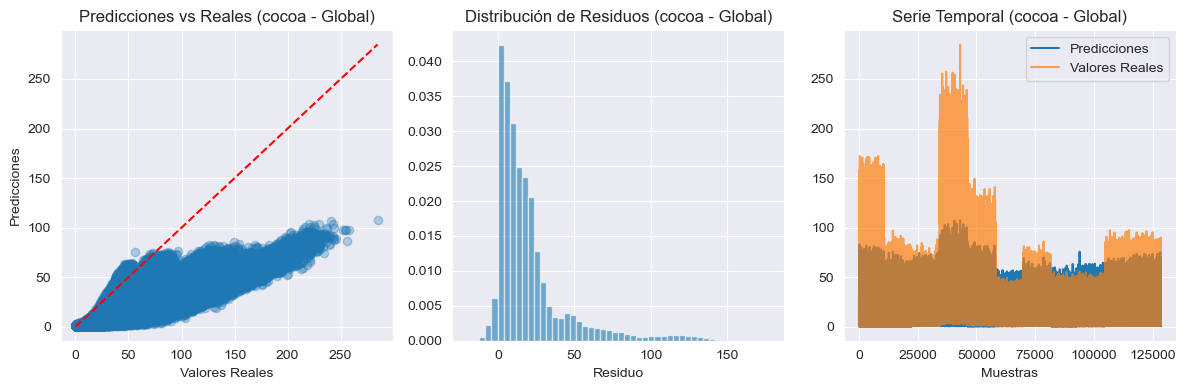


Evaluación del modelo global para el cliente eugene
Cliente eugene - Test MSE: 553.2149, MAE: 13.0103, R2: 0.5638


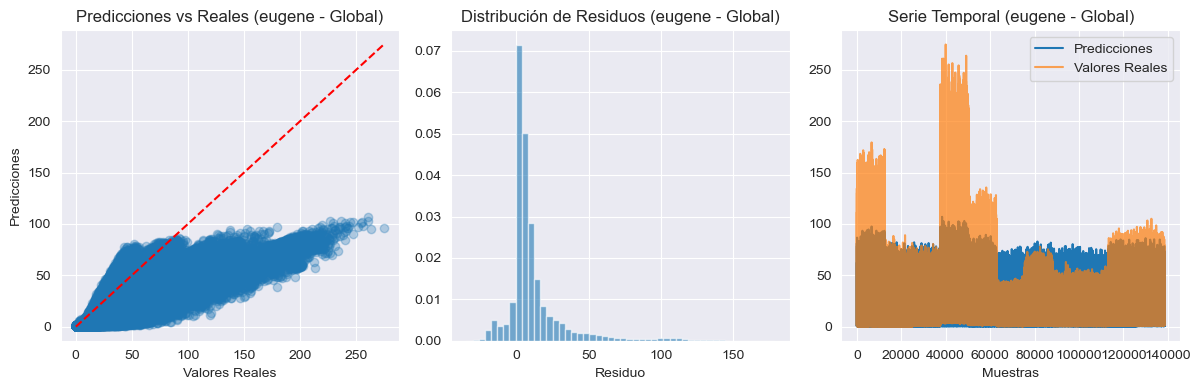


Evaluación del modelo global para el cliente golden
Cliente golden - Test MSE: 1982.1357, MAE: 27.6207, R2: -0.2636


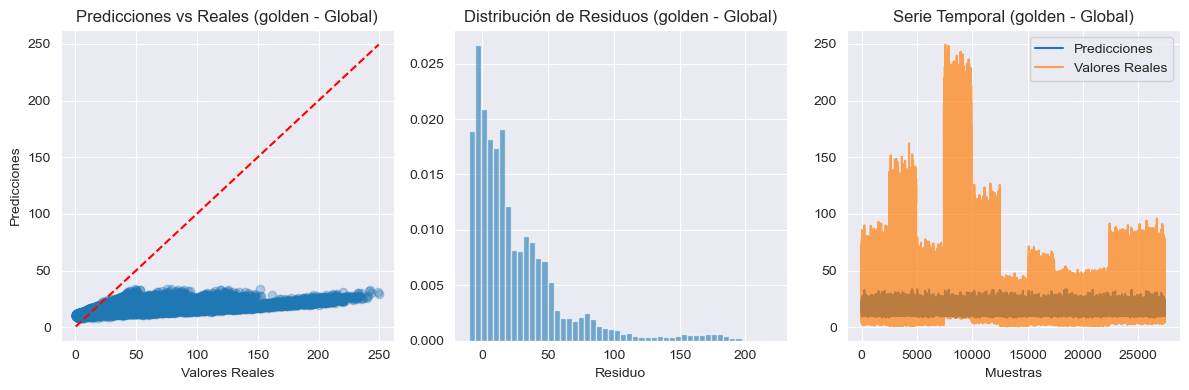


Fine tuning para el cliente cocoa
Fine tuning - Cliente, época 1: Loss = 259.9457
Fine tuning - Cliente, época 2: Loss = 103.9026
Fine tuning - Cliente, época 3: Loss = 84.3992
Fine tuning - Cliente, época 4: Loss = 79.1575
Fine tuning - Cliente, época 5: Loss = 76.6623
Cliente cocoa (Fine Tuning) - Test MSE: 68.3389, MAE: 5.6142, R2: 0.9557


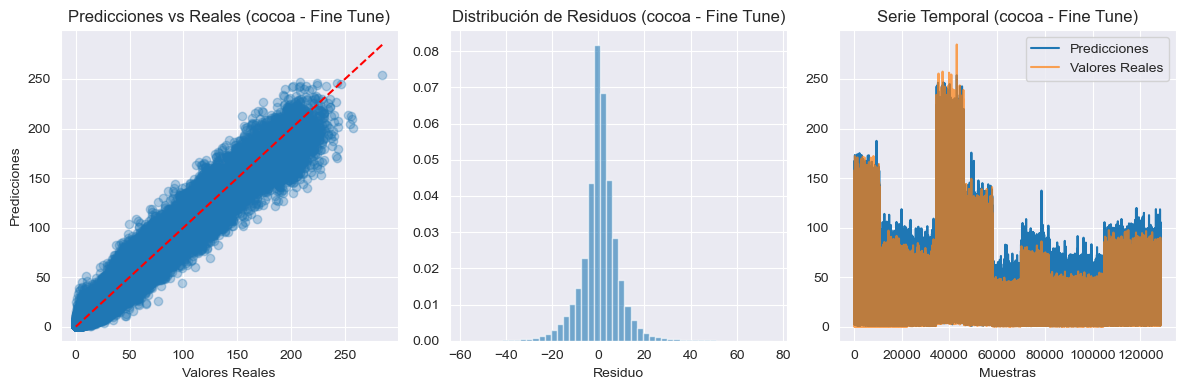

Cliente cocoa (Fine Tuning) en global test - MSE: 490.0943, MAE: 13.0743, R2: 0.6614


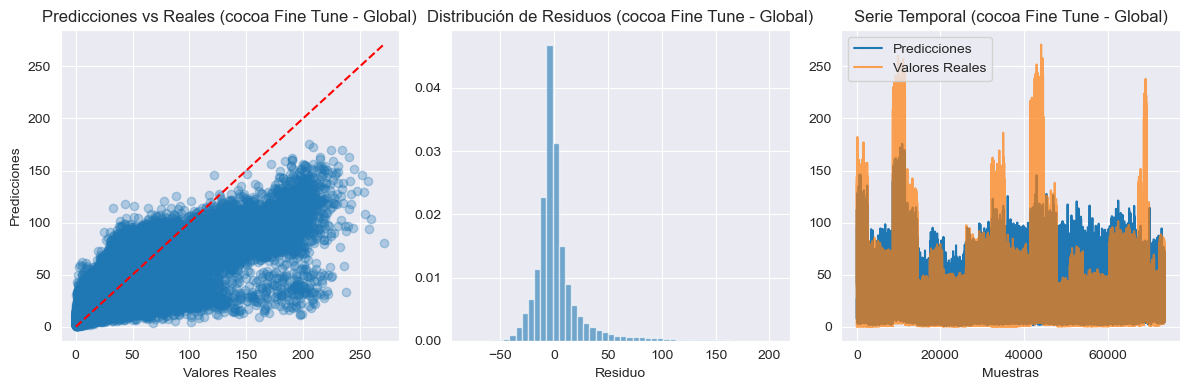


Fine tuning para el cliente eugene
Fine tuning - Cliente, época 1: Loss = 271.5546
Fine tuning - Cliente, época 2: Loss = 174.0260
Fine tuning - Cliente, época 3: Loss = 126.5932
Fine tuning - Cliente, época 4: Loss = 111.5381
Fine tuning - Cliente, época 5: Loss = 104.2723
Cliente eugene (Fine Tuning) - Test MSE: 95.6312, MAE: 5.9723, R2: 0.9246


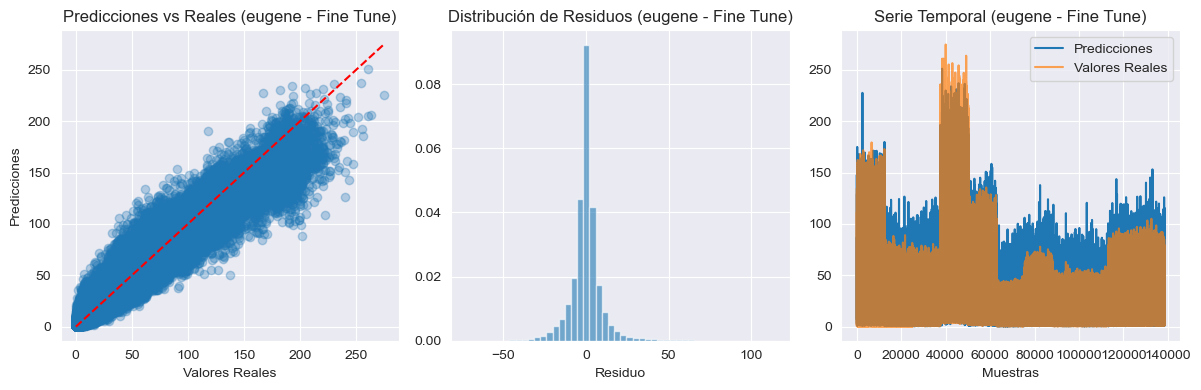

Cliente eugene (Fine Tuning) en global test - MSE: 705.4160, MAE: 14.3462, R2: 0.5126


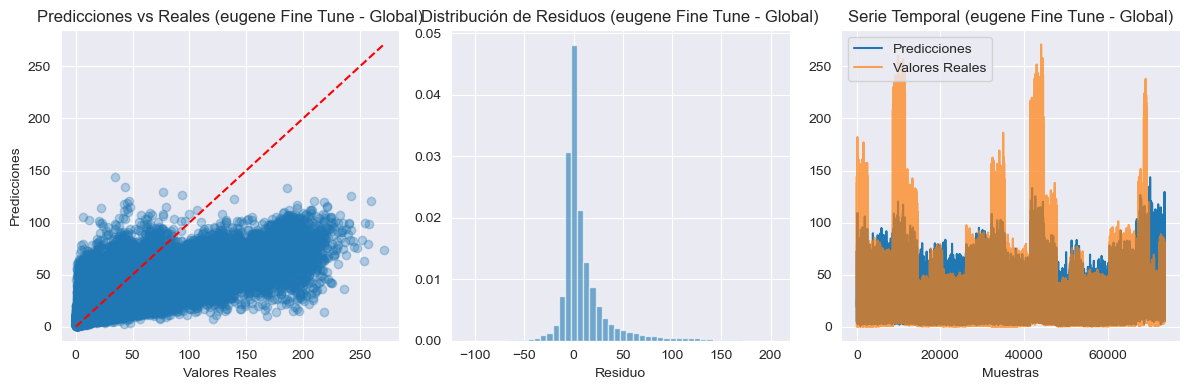


Fine tuning para el cliente golden
Fine tuning - Cliente, época 1: Loss = 1005.7913
Fine tuning - Cliente, época 2: Loss = 966.4102
Fine tuning - Cliente, época 3: Loss = 928.2800
Fine tuning - Cliente, época 4: Loss = 893.0059
Fine tuning - Cliente, época 5: Loss = 862.9050
Cliente golden (Fine Tuning) - Test MSE: 839.6630, MAE: 17.7069, R2: 0.4647


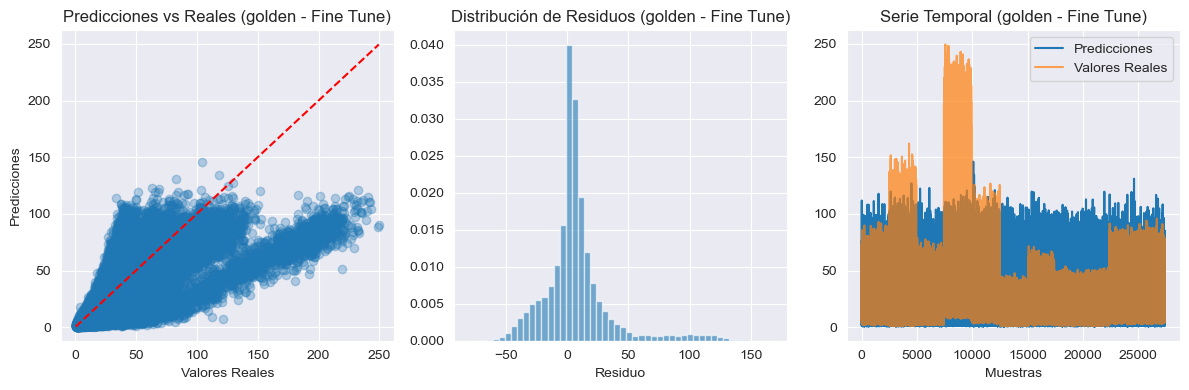

Cliente golden (Fine Tuning) en global test - MSE: 593.6758, MAE: 13.5106, R2: 0.5898


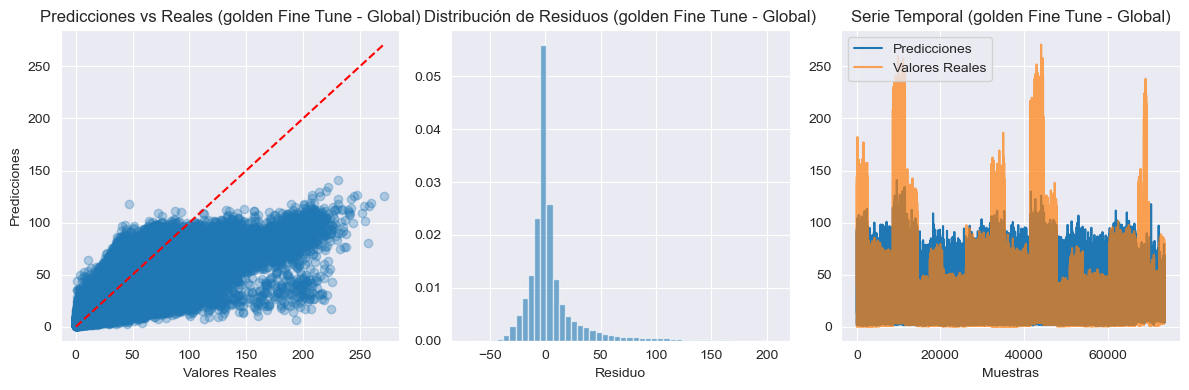

In [17]:
global_model.load_state_dict(torch.load(best_federated_model_path))
global_model.eval()

print("\n=== Evaluación del modelo global ===")
with torch.no_grad():
    y_pred_global = global_model(X_test_tensor).cpu().numpy()
    y_test_np = y_test_tensor.cpu().numpy()
    mse_global = mean_squared_error(y_test_np, y_pred_global)
    mae_global = mean_absolute_error(y_test_np, y_pred_global)
    r2_global = r2_score(y_test_np, y_pred_global)
    print(f"Global Test MSE: {mse_global:.4f}")
    print(f"Global Test MAE: {mae_global:.4f}")
    print(f"Global Test R2: {r2_global:.4f}")
    
    plot_results(y_test_np, y_pred_global, titulo_extra=" (Global)")

for client_name, files in clients.items():
    print(f"\nEvaluación del modelo global para el cliente {client_name}")
    client_df = load_and_preprocess(files, all_sources)
    X_client, y_client, _ = prepare_data(client_df, scaler)
    with torch.no_grad():
        y_pred_client = global_model(X_client).cpu().numpy()
        y_client_np = y_client.cpu().numpy()
        mse_client = mean_squared_error(y_client_np, y_pred_client)
        mae_client = mean_absolute_error(y_client_np, y_pred_client)
        r2_client = r2_score(y_client_np, y_pred_client)
        print(f"Cliente {client_name} - Test MSE: {mse_client:.4f}, MAE: {mae_client:.4f}, R2: {r2_client:.4f}")
        
        plot_results(y_client_np, y_pred_client, titulo_extra=f" ({client_name} - Global)")

def fine_tune_model(model, client_files, scaler, local_epochs_ft=5):
    model_ft = copy.deepcopy(model)
    client_df = load_and_preprocess(client_files, all_sources)
    X_local, y_local, _ = prepare_data(client_df, scaler)
    local_dataset = TensorDataset(X_local, y_local)
    local_loader = DataLoader(local_dataset, batch_size=batch_size, shuffle=True)
    
    optimizer_ft = optim.Adam(model_ft.parameters(), lr=lr * 0.1, weight_decay=weight_decay)
    
    model_ft.train()
    for epoch in range(local_epochs_ft):
        running_loss = 0.0
        for xb, yb in local_loader:
            optimizer_ft.zero_grad()
            outputs = model_ft(xb)
            loss = criterion(outputs, yb)
            loss.backward()
            optimizer_ft.step()
            running_loss += loss.item() * xb.size(0)
        avg_loss = running_loss / len(local_loader.dataset)
        print(f"Fine tuning - Cliente, época {epoch+1}: Loss = {avg_loss:.4f}")
    
    return model_ft

client_finetuned_models = {}

for client_name, files in clients.items():
    print(f"\nFine tuning para el cliente {client_name}")
    model_ft = fine_tune_model(global_model, files, scaler, local_epochs_ft=5)
    client_finetuned_models[client_name] = model_ft
     
    client_df = load_and_preprocess(files, all_sources)
    X_client, y_client, _ = prepare_data(client_df, scaler)
    with torch.no_grad():
        y_pred_ft = model_ft(X_client).cpu().numpy()
        y_client_np = y_client.cpu().numpy()
        mse_ft = mean_squared_error(y_client_np, y_pred_ft)
        mae_ft = mean_absolute_error(y_client_np, y_pred_ft)
        r2_ft = r2_score(y_client_np, y_pred_ft)
        print(f"Cliente {client_name} (Fine Tuning) - Test MSE: {mse_ft:.4f}, MAE: {mae_ft:.4f}, R2: {r2_ft:.4f}")
        
        plot_results(y_client_np, y_pred_ft, titulo_extra=f" ({client_name} - Fine Tune)")

    with torch.no_grad():
        y_pred_ft_global = model_ft(X_test_tensor).cpu().numpy()
        mse_ft_global = mean_squared_error(y_test_np, y_pred_ft_global)
        mae_ft_global = mean_absolute_error(y_test_np, y_pred_ft_global)
        r2_ft_global = r2_score(y_test_np, y_pred_ft_global)
        print(f"Cliente {client_name} (Fine Tuning) en global test - MSE: {mse_ft_global:.4f}, MAE: {mae_ft_global:.4f}, R2: {r2_ft_global:.4f}")
        
        plot_results(y_test_np, y_pred_ft_global, titulo_extra=f" ({client_name} Fine Tune - Global)")

## EVALUACIÓN FINAL DEL MODELO GLOBAL ACTUALIZADO FEDERADAMENTE

C:\Users\Ibon\AppData\Local\Temp\ipykernel_9168\12922757.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  global_model.load_state_dict(torch.load(best_federated_model_pat


=== Evaluación Final del Mejor Modelo Federado ===
Test MSE: 893.5952
Test MAE: 17.6558
Test R2: 0.3826


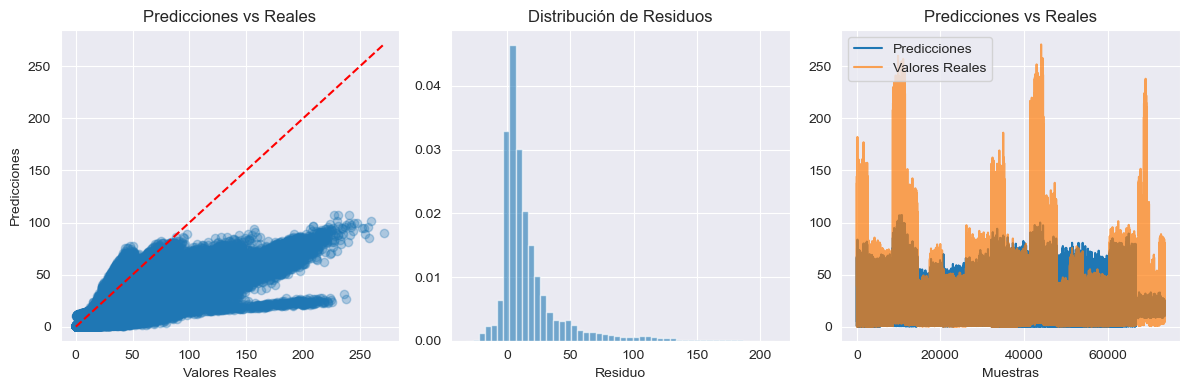

In [18]:
global_model.load_state_dict(torch.load(best_federated_model_path))
global_model.eval()
with torch.no_grad():
    y_pred = global_model(X_test_tensor).cpu().numpy()
    y_test_np = y_test_tensor.cpu().numpy()
    mse = mean_squared_error(y_test_np, y_pred)
    mae = mean_absolute_error(y_test_np, y_pred)
    r2 = r2_score(y_test_np, y_pred)
    print("\n=== Evaluación Final del Mejor Modelo Federado ===")
    print(f"Test MSE: {mse:.4f}")
    print(f"Test MAE: {mae:.4f}")
    print(f"Test R2: {r2:.4f}")

plt.figure(figsize=(12,4))
plt.subplot(131)
plt.title('Predicciones vs Reales')
plt.scatter(y_test_np, y_pred, alpha=0.3)
plt.plot([y_test_np.min(), y_test_np.max()], [y_test_np.min(), y_test_np.max()], 'r--')
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.grid(True)

plt.subplot(132)
residuals = y_test_np - y_pred
plt.hist(residuals, bins=50, density=True, alpha=0.6)
plt.title('Distribución de Residuos')
plt.xlabel('Residuo')
plt.grid(True)

plt.subplot(133)
plt.plot(y_pred, label="Predicciones")
plt.plot(y_test_np, label="Valores Reales", alpha=0.7)
plt.title('Predicciones vs Reales')
plt.xlabel('Muestras')
plt.legend() 
plt.grid(True)
plt.tight_layout()
plt.show()